# Triangular_fuzzy_number_generate_BPA

## Import library

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from scipy.stats import norm
import itertools
from collections import defaultdict
import matplotlib.pyplot as plt

In [2]:
# 1. 加载Iris数据集并划分为训练集和测试集
iris = load_iris()
X = iris.data  # 四个属性
y = iris.target  # 三个类 (0, 1, 2)
num_classes = len(np.unique(iris.target))
num_attributes = iris.data.shape[1]
# 将数据集划分为训练集和测试集，乱序
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

## Get mean and std

In [3]:
# 2. 计算每个类中每个属性的 mean value and standard deviation (无偏估计)

def calculate_mean_std_by_class(X_train, y_train, num_classes):
    mean_std_by_class = []
    for class_label in range(num_classes):
        X_class = X_train[y_train == class_label]
        mean_std = [(np.mean(X_class[:, i]), np.std(X_class[:, i], ddof=1)) for i in range(X_class.shape[1])]
        mean_std_by_class.append(mean_std)
    
    return np.array(mean_std_by_class)

def calculate_mean_std_min_max_by_class(X_train, y_train, num_classes):
    mean_std_by_class = []
    for class_label in range(num_classes):
        X_class = X_train[y_train == class_label]
        mean_std = [(np.mean(X_class[:, i]), np.std(X_class[:, i], ddof=1), np.min(X_class[:, i]), np.max(X_class[:, i])) for i in range(X_class.shape[1])]
        mean_std_by_class.append(mean_std)
    
    return np.array(mean_std_by_class)

mean_std_min_max_by_class = calculate_mean_std_min_max_by_class(X_train, y_train, num_classes)
print("每个类中每个属性的均值，标准差，最小值，最大值:\n", mean_std_min_max_by_class)
print("Shape of mean_std_by_class:\n", mean_std_min_max_by_class.shape)

每个类中每个属性的均值，标准差，最小值，最大值:
 [[[5.045      0.31780497 4.4        5.8       ]
  [3.435      0.36553438 2.3        4.2       ]
  [1.4675     0.16233473 1.         1.9       ]
  [0.235      0.08929927 0.1        0.5       ]]

 [[5.895      0.50380603 4.9        6.8       ]
  [2.7825     0.31532442 2.         3.4       ]
  [4.205      0.47173982 3.         5.        ]
  [1.315      0.20699313 1.         1.8       ]]

 [[6.6025     0.68181037 4.9        7.9       ]
  [2.96       0.33420399 2.2        3.8       ]
  [5.5775     0.59549053 4.5        6.9       ]
  [2.0275     0.27173469 1.4        2.5       ]]]
Shape of mean_std_by_class:
 (3, 4, 4)


In [4]:
p = 0.4

In [5]:
def get_triangular_membership_functions(mean, std, min_val, max_val, p=0.4):

    u = max_val + p * std  
    l = min_val - p * std  

    def triangular_membership_function(x):
        if x < l:
            return 0  
        elif x > u:
            return 0  
        elif l <= x <= mean:
            return (x - l) / (mean - l)
        elif mean < x <= u:
            return (u - x) / (u - mean)
        else:
            return 0  
    return triangular_membership_function

In [6]:
def get_triangular_membership_functions_list(mean_std_by_class):
    triangular_membership_functions_by_class = []
    for class_data in mean_std_by_class:
        class_functions = []
        for attr_data in class_data:
            mean, std, min_val, max_val = attr_data
            membership_function = get_triangular_membership_functions(mean, std, min_val, max_val)
            class_functions.append(membership_function)
        triangular_membership_functions_by_class.append(class_functions)
    return np.array(triangular_membership_functions_by_class)

triangular_membership_functions_by_class = get_triangular_membership_functions_list(mean_std_min_max_by_class)
triangular_membership_functions_by_class.shape

(3, 4)

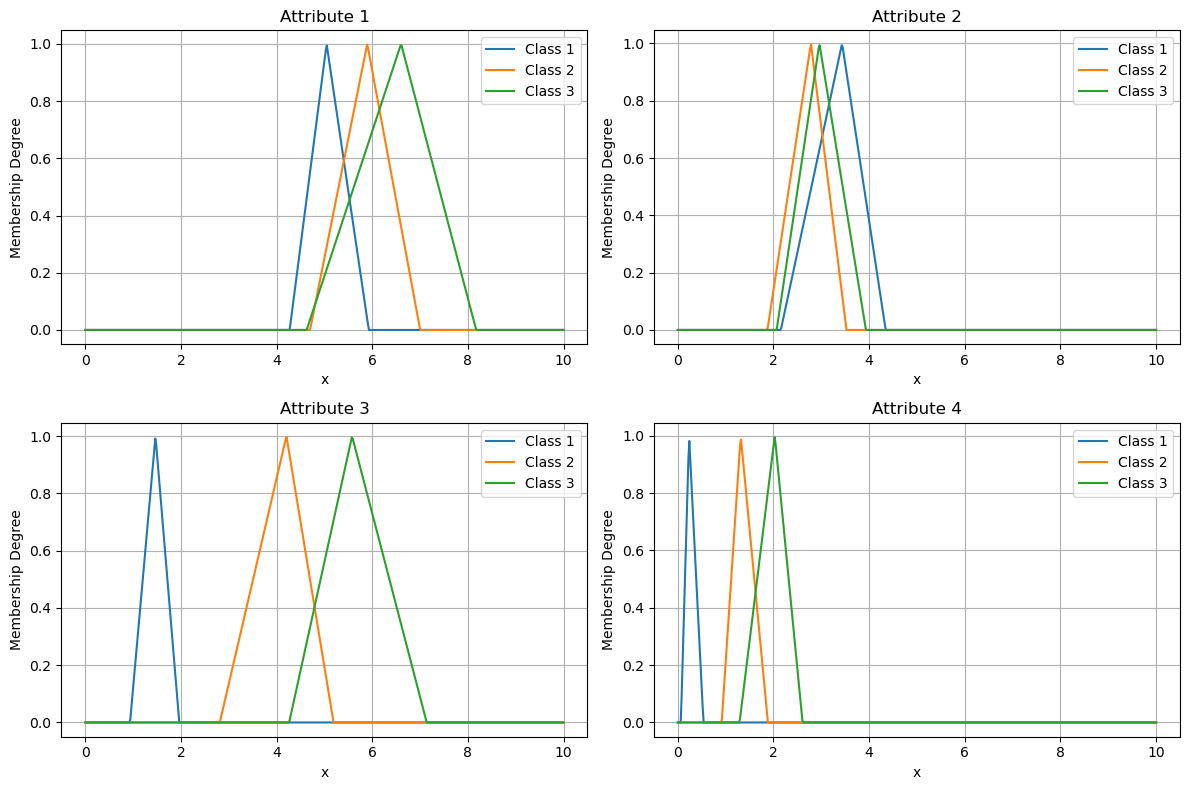

In [7]:
def plot_triangular_membership_functions(triangular_membership_functions_by_class):
    num_classes, num_attributes = triangular_membership_functions_by_class.shape
    
    # Generate x values for plotting
    x_values = np.linspace(0, 10, 500)  # Assuming a reasonable range for x (e.g., [0, 10])
    
    # Determine number of rows and columns for subplots
    num_rows = (num_attributes + 1) // 2  # Two plots per row
    num_cols = 2
    
    # Create subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 4 * num_rows))
    axes = axes.flatten()  # Flatten the axes array to make indexing easier
    
    # Plot membership functions for each attribute
    for attr_index in range(num_attributes):
        ax = axes[attr_index]
        for class_index in range(num_classes):
            # Get the triangular membership function for the given class and attribute
            membership_function = triangular_membership_functions_by_class[class_index][attr_index]
            # Calculate the y values by passing x values through the membership function
            y_values = [membership_function(x) for x in x_values]
            # Plot the curve for this class
            ax.plot(x_values, y_values, label=f'Class {class_index + 1}')
        
        # Add titles and labels
        ax.set_title(f'Attribute {attr_index + 1}')
        ax.set_xlabel('x')
        ax.set_ylabel('Membership Degree')
        ax.legend()
        ax.grid(True)
    
    # Remove any unused subplots
    if num_attributes % 2 != 0:
        fig.delaxes(axes[-1])

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

plot_triangular_membership_functions(triangular_membership_functions_by_class)

In [8]:
sample = np.random.randint(0, len(X_test))
test_sample = (X_test[sample], y_test[sample])
test_sample

(array([6.8, 3. , 5.5, 2.1]), 2)

In [9]:

def calculate_membership_for_sample(test_sample, triangular_membership_functions_by_class):

    test_values, true_class = test_sample  # 获取属性值和真实类别
    num_classes = len(triangular_membership_functions_by_class)
    num_attributes = len(test_values)
    
    # 初始化一个存储隶属度值的列表
    membership_values = []
    
    for class_idx in range(num_classes):
        class_membership_values = []
        for attr_idx in range(num_attributes):
            # 获取对应类和属性的三角隶属函数
            membership_function = triangular_membership_functions_by_class[class_idx][attr_idx]
            # 计算该属性值的隶属度
            membership_value = membership_function(test_values[attr_idx])
            class_membership_values.append(membership_value)
        membership_values.append(class_membership_values)
    
    return np.array(membership_values)


# Calculate the membership values for the test sample
membership_values = calculate_membership_for_sample(test_sample, triangular_membership_functions_by_class)

membership_values  # This will output the membership values for each class and attribute


array([[0.        , 0.6604782 , 0.        , 0.        ],
       [0.1821223 , 0.70751574, 0.        , 0.        ],
       [0.87422178, 0.95891881, 0.94109582, 0.87525677]])

In [10]:
def plot_triangular_membership_functions_with_sample(triangular_membership_functions_by_class, test_sample):
    test_values, true_class = test_sample  # 获取属性值和真实类别
    num_classes = len(triangular_membership_functions_by_class)
    num_attributes = len(test_values)
    
    # Generate x values for plotting
    x_values = np.linspace(0, 10, 500)  # 假设x的合理范围 (例如 [0, 10])
    
    # Determine number of rows and columns for subplots
    num_rows = (num_attributes + 1) // 2  # 两个图每行
    num_cols = 2
    
    # Create subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 4 * num_rows))
    axes = axes.flatten()  # Flatten the axes array to make indexing easier
    
    # Plot membership functions for each attribute
    for attr_index in range(num_attributes):
        ax = axes[attr_index]
        for class_index in range(num_classes):
            # Get the triangular membership function for the given class and attribute
            membership_function = triangular_membership_functions_by_class[class_index][attr_index]
            # Calculate the y values by passing x values through the membership function
            y_values = [membership_function(x) for x in x_values]
            # Plot the curve for this class
            ax.plot(x_values, y_values, label=f'Class {class_index + 1}')
        
        # 绘制测试样本的隶属度点
        for class_index in range(num_classes):
            membership_function = triangular_membership_functions_by_class[class_index][attr_index]
            test_value = test_values[attr_index]  # 获取测试样本的属性值
            test_membership_value = membership_function(test_value)  # 计算测试样本的隶属度
            # 在图上标记测试样本的隶属度值
            ax.plot(test_value, test_membership_value, 'ro')  # 红点表示测试样本值
            ax.text(test_value, test_membership_value, f'{test_membership_value:.2f}', fontsize=12, color='red')
        
        # Add titles and labels
        ax.set_title(f'Attribute {attr_index + 1}')
        ax.set_xlabel('x')
        ax.set_ylabel('Membership Degree')
        ax.legend()
        ax.grid(True)
    
    # Remove any unused subplots
    if num_attributes % 2 != 0:
        fig.delaxes(axes[-1])

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

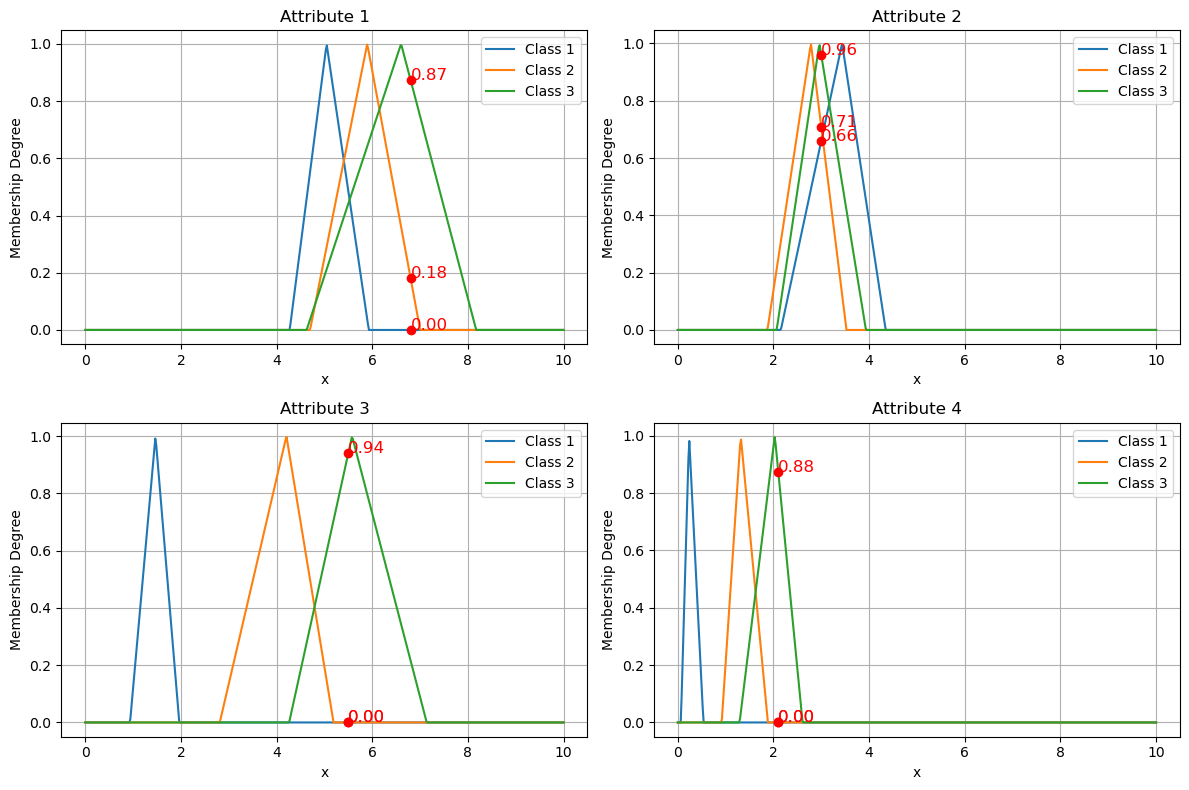

In [11]:
plot_triangular_membership_functions_with_sample(triangular_membership_functions_by_class, test_sample)

In [12]:
def sort_membership(membership_values):
    sorted_indices = np.argsort(-membership_values, axis=0)  # 降序排序，使用负号实现降序
    sorted_mv = np.take_along_axis(membership_values, sorted_indices, axis=0)  # 按照索引排序后的值
    return sorted_indices, sorted_mv

In [13]:
sorted_indices, sorted_mv = sort_membership(membership_values)

In [14]:
print("\nsorted_indices\n", sorted_indices)
print("\nsorted_mv\n", sorted_mv)


sorted_indices
 [[2 2 2 2]
 [1 1 0 0]
 [0 0 1 1]]

sorted_mv
 [[0.87422178 0.95891881 0.94109582 0.87525677]
 [0.1821223  0.70751574 0.         0.        ]
 [0.         0.6604782  0.         0.        ]]


In [15]:
def process_sorted_mv(sorted_mv):
    col_sum = np.sum(sorted_mv, axis=0)
    
    num_classes, num_attributes = sorted_mv.shape
    result = np.zeros((num_classes, num_attributes))
    
    result[:num_classes, :] = sorted_mv
    
    for i in range(num_attributes): 
        result[:num_classes, i] = sorted_mv[:, i] / col_sum[i] 
    
    return result

In [16]:
normalized_sorted_mv = process_sorted_mv(sorted_mv)
normalized_sorted_mv

array([[0.82759187, 0.41209917, 1.        , 1.        ],
       [0.17240813, 0.3040577 , 0.        , 0.        ],
       [0.        , 0.28384313, 0.        , 0.        ]])

In [17]:
np.sum(normalized_sorted_mv, axis=0)

array([1., 1., 1., 1.])

In [18]:
print("\nsorted_indices\n", sorted_indices)


sorted_indices
 [[2 2 2 2]
 [1 1 0 0]
 [0 0 1 1]]


In [21]:
def generate_bpa(normalized_sorted_mv, sorted_indices):
    dict_list = []

    num_FOD, num_attribute = normalized_sorted_mv.shape

    for i in range(num_attribute):
        dict_i = {}
        for j in range(num_FOD):
            A = tuple(sorted_indices[:j + 1, i])
            MA = normalized_sorted_mv[j, i]
            dict_i[A] = MA
        dict_list.append(dict_i)
            
    return dict_list

In [22]:
bpa_results = generate_bpa(normalized_sorted_mv, sorted_indices)
bpa_results

[{(2,): 0.8275918738427661, (2, 1): 0.17240812615723392, (2, 1, 0): 0.0},
 {(2,): 0.4120991679946972,
  (2, 1): 0.3040577014797397,
  (2, 1, 0): 0.2838431305255632},
 {(2,): 1.0, (2, 0): 0.0, (2, 0, 1): 0.0},
 {(2,): 1.0, (2, 0): 0.0, (2, 0, 1): 0.0}]

In [23]:
def right_intersection(A, B):
    """
    右正交 (RI)，即 B 中去除不在 A 中的元素
    """
    return tuple(item for item in B if item in A)


def left_intersection(A, B):
    """
    左正交 (LI)，即 A 中去除不在 B 中的元素
    """
    return tuple(item for item in A if item in B)


def calculate_KR(M1, M2):
    """
    计算右正交和的 K^R (K_R)
    """
    K_R = 0
    for B, w1 in M1.items():
        for C, w2 in M2.items():
            if right_intersection(B, C) == ():
                K_R += w1 * w2
    return K_R


def calculate_KL(M1, M2):
    """
    计算左正交和的 K^L (K_L)
    """
    K_L = 0
    for B, w1 in M1.items():
        for C, w2 in M2.items():
            if left_intersection(B, C) == ():
                K_L += w1 * w2
    return K_L


def ROS(M1, M2):
    """
    右正交和 (ROS)
    """
    K_R = calculate_KR(M1, M2)
    result = dict()

    if K_R != 1:  # 防止 K_R 为 1 时出现除以 0 的情况
        for A, w1 in M1.items():
            weight_sum = 0
            for B, w1 in M1.items():
                for C, w2 in M2.items():
                    if right_intersection(B, C) == A:
                        weight_sum += w1 * w2
            if weight_sum > 0:
                result[A] = (1 / (1 - K_R)) * weight_sum            
    return result


def LOS(M1, M2):
    """
    左正交和 (LOS)
    """
    K_L = calculate_KL(M1, M2)
    result = dict()

    if K_L != 1:  # 防止 K_L 为 1 时出现除以 0 的情况
        for A, w1 in M1.items():
            weight_sum = 0
            for B, w1 in M1.items():
                for C, w2 in M2.items():
                    if left_intersection(B, C) == A:
                        weight_sum += w1 * w2
            if weight_sum > 0:
                result[A] = (1 / (1 - K_L)) * weight_sum
    return result



In [25]:
# 连续右正交和
def continuous_right_orthogonal_sum(PMFs):
    """
    连续执行右正交和操作
    :param PMFs: 输入的PMF列表
    :return: 最终的右正交和结果
    """
    result = PMFs[0]
    for i in range(1, len(PMFs)):
        result = ROS(result, PMFs[i])
    return result

# 连续左正交和
def continuous_left_orthogonal_sum(PMFs):
    """
    连续执行左正交和操作
    :param PMFs: 输入的PMF列表
    :return: 最终的左正交和结果
    """
    result = PMFs[0]
    for i in range(1, len(PMFs)):
        result = LOS(result, PMFs[i])
    return result

In [26]:
continuous_left_orthogonal_sum(bpa_results)

{(2,): 1.0000000000000002}

In [27]:
continuous_right_orthogonal_sum(bpa_results)

{(2,): 1.0000000000000002}